# Catalonia drought

This script is using a sample from the ERA5--Drought data set from the European Centre for Medium-range Weather Forecasts (ECMWF) and plots a timeseries for a subset of the dataset. 
The output of this notebook is published as Figure 6 in 
> Keune, J., F. Di Giuseppe, C. Barnard, E. Damasio da Costa, and F. Wetterhall (XXXX): \textbf{ERA5--Drought: Global drought indicators based on ECMWF reanalysis}, submitted to Scientific Data. 

## Setup and Settings

#### Load libraries

In [1]:
import os 
import sys
import math
import datetime as dt
import pandas as pd
import netCDF4 as nc4
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import geopandas as gpd
import fiona
import regionmask
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator
import string
from dateutil import relativedelta

#### Some helpful functions

In [2]:
EARTHRADIUS = 6371  # earth radius [km]
def calculate_gridarea(lats_centr, res, nlon):

    lats1 = (lats_centr + (res / 2)) * np.pi / 180  # np.sin requires radians
    lats2 = (lats_centr - (res / 2)) * np.pi / 180
    areas = (
        (np.pi / 180) * (EARTHRADIUS ** 2) * np.abs(np.sin(lats1) - np.sin(lats2)) * res
    )

    ## overwrite any areas of 0 (at the poles) with np.NaN to prevent problems
    areas[np.where(areas == 0.0)] = np.NaN  
    # return array of dimension nlat x nlon
    area_2d = np.swapaxes(np.tile(areas, (nlon, 1)), 0, 1)
    return area_2d

#### General settings

In [3]:
ipath = "/ec/vol/centaur/nejk/drought_monitor/"

### Landmask

In [4]:
# binary land mask
lfile      = f"{ipath}/landmask_era5_global.nc"
lmask      = xr.open_dataset(lfile)['lsm']
lmask      = lmask.where( lmask.values == 1 ) # set 0s to nan
# land fraction
lffile     = f"{ipath}/landmask_era5_global_frac.nc"
lmask_frac = xr.open_dataset(lffile)['var172']

In [5]:
area_2d = calculate_gridarea(lmask.lat, res=abs(lmask.lat[1]-lmask.lat[0]), nlon=len(lmask.lon))*lmask[0,:,:]
area_2d = xr.DataArray(area_2d, coords={'lat': lmask.lat,'lon': lmask.lon}, dims=["lat", "lon"])
#area_2d.plot()

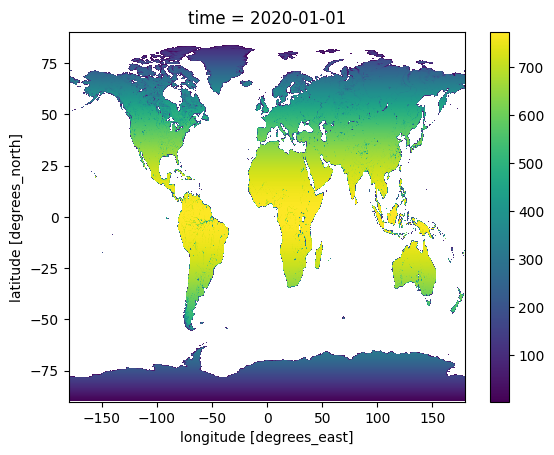

In [6]:
# adjust using land fraction
area_2d_adj = area_2d * lmask_frac
area_2d_adj = area_2d_adj.where( area_2d_adj.values != 0 ) # set 0s to nan
area_2d_adj.plot()

## Drought indices

### Read SPI

In [7]:
spi12 = xr.open_mfdataset(os.path.join(ipath, "spi/spi12/SPI12_gamma_global_era5_moda_ref1991to2020_*12.nc"))
print(spi12)

<xarray.Dataset> Size: 698MB
Dimensions:  (time: 84, lon: 1440, lat: 721)
Coordinates:
  * time     (time) datetime64[ns] 672B 1940-12-01T06:00:00 ... 2023-12-01T06...
  * lon      (lon) float64 12kB -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * lat      (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
Data variables:
    SPI12    (time, lat, lon) float64 698MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    source:       DRYFALL v0.1
    institution:  ECMWF
    title:        SPI12
    description:  Drought Index: Standardized Drought Index calculated accord...
    history:      Thu Feb 15 09:50:03 2024: cdo -selyear,1940 -selmon,12 /scr...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...


### Read SPEI

In [8]:
spei12 = xr.open_mfdataset(os.path.join(ipath, "spei/spei12/SPEI12_genlogistic_global_era5_moda_ref1991to2020_*12.nc"))
print(spei12)

<xarray.Dataset> Size: 698MB
Dimensions:  (time: 84, lon: 1440, lat: 721)
Coordinates:
  * time     (time) datetime64[ns] 672B 1940-12-01T06:00:00 ... 2023-12-01T06...
  * lon      (lon) float64 12kB -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * lat      (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
Data variables:
    SPEI12   (time, lat, lon) float64 698MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    source:       DRYFALL v0.1
    institution:  ECMWF
    title:        SPEI12
    description:  Drought Index: Standardized Drought Index calculated accord...
    history:      Thu Feb 15 13:46:41 2024: cdo -selyear,1940 -selmon,12 /scr...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...


### Mask data

#### Barren mask

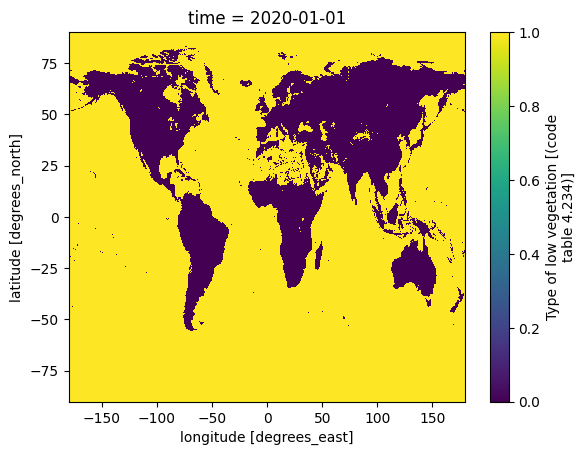

In [9]:
vfile = f"{ipath}/barren_mask.nc"
bmask = xr.open_dataset(vfile)['barren_mask']
bmask_3d = bmask.reindex_like(spei12, method="nearest")
bmask.plot()

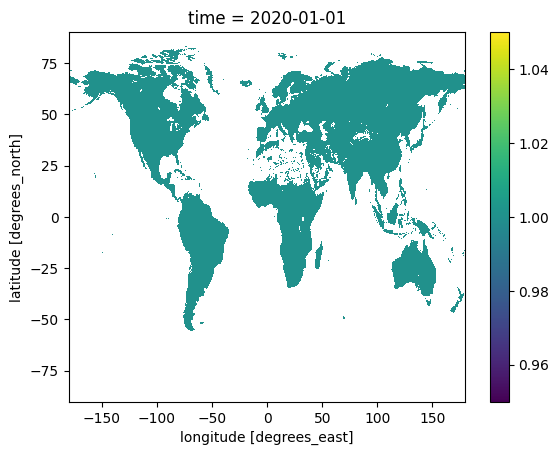

In [10]:
vlmask = xr.where( (bmask == 0) & (lmask == 1), 1, np.nan)
vlmask.plot()
lmask_3d  = lmask.reindex_like(spi12, method="nearest")
vlmask_3d = vlmask.reindex_like(spi12, method="nearest")

#### Reliability data | SPI

In [11]:
sfile = f"{ipath}/spi/spi12/parameter/SPI12_gamma_global_era5_moda_ref1991to2020_params_updated.nc"
params_spi12 = xr.open_dataset(sfile).sel(time="1900-12-01")
sig_spi12 = xr.where(params_spi12['significance'] == 1, 1, np.nan)
p0_spi12  = xr.where(params_spi12['pzero'] <= 0.1, 1, np.nan)

In [12]:
#spi12_masked = xr.where( (vlmask_3d == 1) & (sig_spi12 == 1), spi12, np.nan)
spi12_masked = xr.where( (vlmask_3d == 1) & (sig_spi12 == 1) & (p0_spi12 == 1), spi12, -9999) # set masked values to -9999 (shown grey)
spi12_masked = xr.where( np.isnan(lmask_3d), np.nan, spi12_masked) # set ocean to nan (shown white)

In [13]:
#spi12_masked.isel(time=82)['SPI12'].plot(vmax=3, vmin=-3)

#### Reliability data | SPEI

In [14]:
sfile = f"{ipath}/spei/spei12/parameter/SPEI12_genlogistic_global_era5_moda_ref1991to2020_params_updated.nc"
params_spei12 = xr.open_dataset(sfile).sel(time="1900-12-01")
sig_spei12 = xr.where(params_spei12['significance'] == 1, 1, np.nan)

In [15]:
spei12_masked = xr.where( (vlmask_3d == 1) & (sig_spei12 == 1), spei12, -9999) # set masked values to -9999 (shown grey)
spei12_masked = xr.where( np.isnan(lmask_3d), np.nan, spei12_masked) # set ocean to nan (shown white)

## Catalonia

### Define region

In [16]:
nutsid    = "ES51"

In [17]:
nutsshp   = "./data/metadata/NUTS_RG_20M_2021_4326/NUTS_RG_20M_2021_4326.shp"
shapefile = fiona.open(nutsshp)
for feature in shapefile:
    if (feature['properties']['FID'] == nutsid):
        print(feature['properties']['NUTS_ID'])
        print(feature['properties']['LEVL_CODE'])
        print(feature['properties']['NUTS_NAME'])
        print(feature['properties']['NAME_LATN'])
        with fiona.open(f'./data/metadata/{nutsid}.shp', 'w', **shapefile.meta) as output:
            output.write(feature)
nutsshp = gpd.read_file(f'./data/metadata/{nutsid}.shp')

ES51
2
Cataluña
Cataluña


In [18]:
robinson = ccrs.Robinson().proj4_init
nutsshp_rob = nutsshp.to_crs(robinson)

In [19]:
lon1 = math.floor(nutsshp_rob.bounds.minx[0])
lon2 = math.ceil(nutsshp_rob.bounds.maxx[0])
lat1 = math.floor(nutsshp_rob.bounds.miny[0])
lat2 = math.ceil(nutsshp_rob.bounds.maxy[0])
print(f"Bounding box: lats {lat1} to {lat2}, lons {lon1} to {lon2}")
# Minor adjustments to lon boundaries for aesthetics
lat1 -= 25000
lat2 += 50000
lon1 -= 10000
lon2 += 500
print(f"Bounding box: lats {lat1} to {lat2}, lons {lon1} to {lon2}")

Bounding box: lats 4331892 to 4578789, lons 14814 to 282170
Bounding box: lats 4306892 to 4628789, lons 4814 to 282670


<xarray.DataArray 'mask' (lat: 721, lon: 1440)> Size: 8MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float64 12kB -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
Attributes:
    standard_name:  region
(84, 721, 1440)


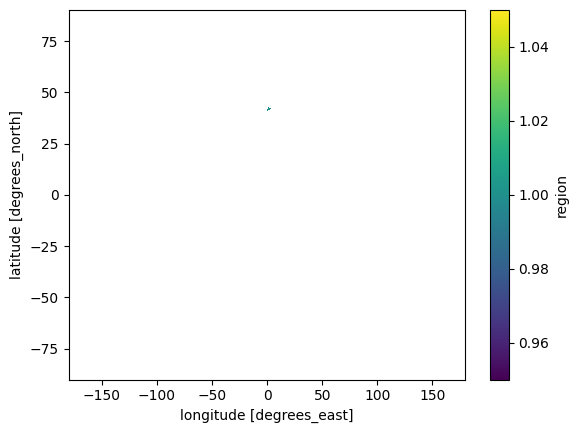

In [20]:
# get mask of grid points in nuts region
nutsmask = regionmask.mask_geopandas(nutsshp, spei12.lon, spei12.lat)
#print(nutsmask.shape)
#nutsmask.plot()
nutsmask_xr = xr.DataArray(nutsmask, coords={'lat': spei12.lat, 'lon': spei12.lon}, dims=["lat", "lon"])
nutsmask_xr = nutsmask_xr.where( nutsmask_xr.values == 0, np.nan) # to get nan in all other cases, 0 otherwise
nutsmask_xr = nutsmask_xr.where( np.isnan(nutsmask_xr.values), 1) # to set the 0 from regionmask to 1
print(nutsmask_xr)
nutsmask_xr.plot()
nutsmask_3d_xr = nutsmask_xr.expand_dims(dim={"time": spei12.time}, axis=0)
print(nutsmask_3d_xr.shape)

### Area in drought

In [21]:
# calculate area in drought
area_3d_adj = area_2d_adj.reindex_like(spi12, method="nearest")
aid_spi = {}
aid_spei = {}

window = 12
swindow=f"w{window}"
aid_spi[swindow] = {}
aid_spei[swindow] = {}

for severity in ['moderate','severe','extreme','any']:
        
    if severity == "mild":
        thresh_min = -1
        thresh_max = 0
    if severity == "moderate":
        thresh_min = -1.5
        thresh_max = -1
    if severity == "severe":
        thresh_min = -2
        thresh_max = -1.5
    if severity == "extreme":
        thresh_min = -999
        thresh_max = -2
    if severity == "any":
        thresh_min = -999
        thresh_max = -1

    rspi   = spi12_masked * nutsmask_3d_xr
    dmask  = xr.where((rspi > thresh_min) & (rspi <= thresh_max) & (rspi != -9999), 1, np.nan)
    tmp    = 100 * (dmask*area_3d_adj).sum(dim=["lat", "lon"]) / (nutsmask_3d_xr*area_3d_adj).sum(dim=["lat", "lon"])
    aid_spi[swindow][severity] = tmp.to_pandas() 

    del(tmp, dmask)

    rspei  = spei12_masked * nutsmask_3d_xr
    dmask  = xr.where((rspei > thresh_min) & (rspei <= thresh_max) & (rspei != -9999), 1, np.nan)
    tmp    = 100 * (dmask*area_3d_adj).sum(dim=["lat", "lon"]) / (nutsmask_3d_xr*area_3d_adj).sum(dim=["lat", "lon"])
    aid_spei[swindow][severity] = tmp.to_pandas()

    del(tmp, dmask)

### Plot timeseries of area in drought

In [22]:
mylevels     = [-10000,-1000,-2,-1.5,-1,1,1.5,2,1000]
mycollisthex = ['#bebebe','#663300','#8c6640','#b29980','#ffffff','#99b280','#668c40','#336600']

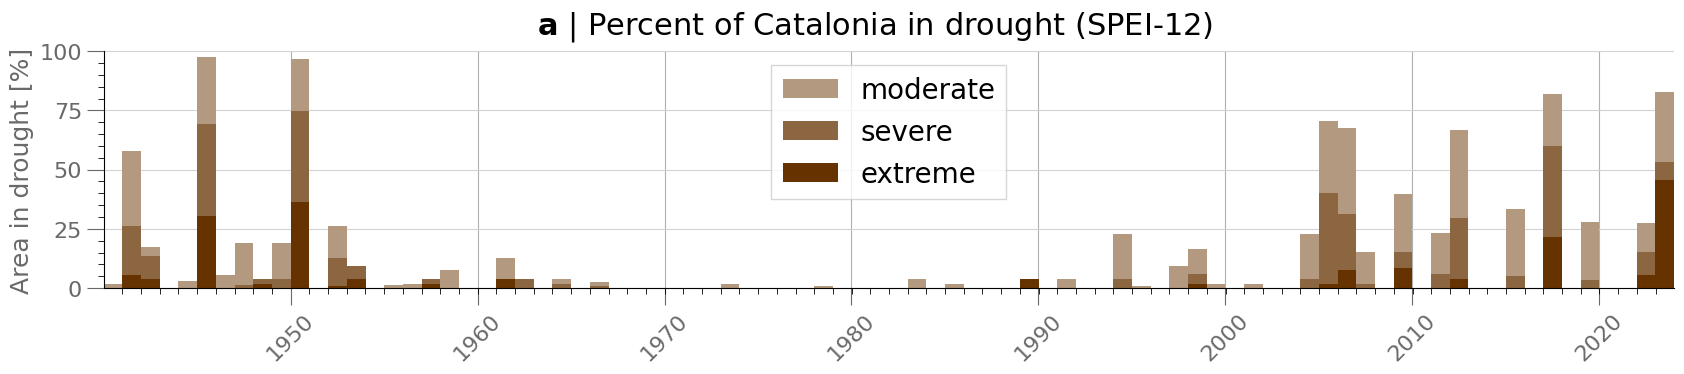

In [27]:
fig, ax1 = plt.subplots(1,1, figsize=(18,4))
title1 = r"$\bf{" + f"{string.ascii_lowercase[0]}" + "}$"
fig.suptitle(f"{title1} | Percent of Catalonia in drought (SPEI-{window})", fontsize=22)
fig.tight_layout(pad=3.75)
fig.subplots_adjust(top=0.875)
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 20}
plt.rc('font', **font)

severities = ['extreme','severe','moderate']
pidata2 = aid_spei[f'w{window}']['extreme']['SPEI12']
pidata3 = aid_spei[f'w{window}']['severe']['SPEI12']
pidata4 = aid_spei[f'w{window}']['moderate']['SPEI12']
apidata = pd.concat([pidata2, pidata3, pidata4], axis=1)
apidata.index = apidata.index.shift(-(window-1), freq="MS") # shift datetimeindex to get start date
bottom = np.zeros(len(apidata.index))
for i in range(len(apidata.columns)):
    p = ax1.bar(apidata.index, apidata.iloc[:,i], facecolor=mycollisthex[i+1], 
                alpha=1, 
                width=relativedelta.relativedelta(months=window), 
                label=severities[i], 
                bottom=bottom,
                align='edge')
    bottom += apidata.iloc[:,i]
ax1.set_ylabel("Area in drought [%]", size=18)
ax1.legend(ncol=1, loc='upper center', fancybox=False, shadow=False, reverse=True)
ax1.margins(x=0)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(axis='both', colors='dimgrey')
ax1.xaxis.label.set_color('dimgrey')
ax1.yaxis.label.set_color('dimgrey')
ax1.minorticks_on()
ax1.xaxis.set_minor_locator(AutoMinorLocator(10))
ax1.tick_params(which='minor', length=4)
ax1.tick_params(which='major', length=12)
ax1.grid(True)
ax1.set_axisbelow(True)
ax1.yaxis.grid(color='lightgray', linestyle='solid') #dashed
ax1.set_ylim([0,100])
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
    
plt.savefig("figures/Figure6a_Catalonia_timeseries.pdf", dpi=300, format=None, metadata=None,
            bbox_inches=None, pad_inches=0.1,
            facecolor='auto', edgecolor='auto',
            backend=None)
plt.show()

### Plot maps for specific events

1945-12


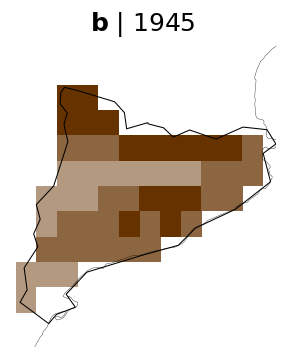

1950-12


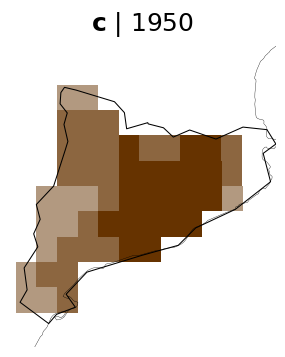

2017-12


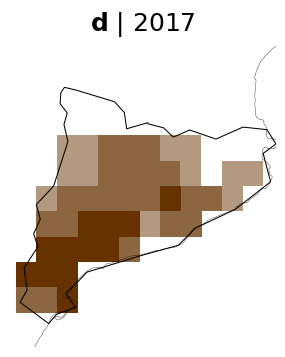

2023-12


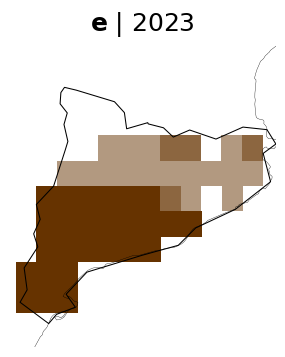

In [24]:
mylevels     = [-10000,-1000,-2,-1.5,-1,1,1.5,2,1000]
mycollisthex = ['#bebebe','#663300','#8c6640','#b29980','#ffffff','#99b280','#668c40','#336600']
legnames     = ["masked","extremely dry", "severely dry", "moderately dry", "near normal", "moderately wet", "severely wet", "extremely wet"]

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

i = 1
for itime in [5, 10, 77, 83]:
    toplot       = spei12_masked.isel(time=itime)['SPEI12'] * nutsmask_3d_xr.isel(time=itime)
    print(str(toplot.time.values)[:7])
    
    plt.figure(figsize=(4.5, 4));
    ax = plt.axes(projection=ccrs.Robinson(), frameon=False);
    ax.coastlines(color='black', lw=0.25)
    toplot.plot(ax=ax, transform=ccrs.PlateCarree(),
                              x='lon', y='lat',
                              add_colorbar=False,
                              colors=mycollisthex,
                              levels=mylevels)
    nutsshp_rob.plot(facecolor="#00000000", color="#00000000", edgecolor='black', linewidth = 0.75, ax=ax)
    ax.set_xlim([lon1,lon2])
    ax.set_ylim([lat1,lat2])
    title1 = r"$\bf{" + f"{string.ascii_lowercase[i]}" + "}$"
    ax.set_title(f"{title1} | {str(toplot.time.values)[:4]}", size=18)

    plt.savefig(f"figures/Figure6{string.ascii_lowercase[i]}_Catalonia_map_{str(toplot.time.values)[:4]}.pdf", dpi=300, format=None, metadata=None,
            bbox_inches=None, pad_inches=0.1,
            facecolor='auto', edgecolor='auto',
            backend=None)
    plt.show()
    i += 1
    